In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from src.strategy import SeasonalETF
import matplotlib.pyplot as plt

#%matplotlib inline

In [2]:
# Initialize the strategy (Start in 2020)
strat = SeasonalETF(start_date='2020-01-01')

# Run pipeline
strat.get_universe()
strat.ingest_data()
strat.calculate_seasonality()
strat.run_backtest(initial_capital=10000)

--- Fetching NASDAQ 100 Universe ---
Successfully loaded 102 tickers.

--- Ingesting Data (Start: 2010-01-01) ---
Data Loaded. Tradable Universe: 101 tickers.

--- Calculating Seasonal Metrics ---
Seasonal Rankings Calculated.

--- Running Backtest (Cost: 0.0%) ---
Backtest Complete.
Final Capital: $47,201.32
Total Return:  372.01%


,Total Value,Monthly Return
Date,,
2010-01-29,10000.000000,0.000000
2010-02-26,10000.000000,0.000000
2010-03-31,10000.000000,0.000000
2010-04-30,10000.000000,0.000000
2010-05-31,10000.000000,0.000000
...,...,...
2025-09-30,44123.865161,0.063781
2025-10-31,47899.609354,0.085571
2025-11-28,43604.725549,-0.089664


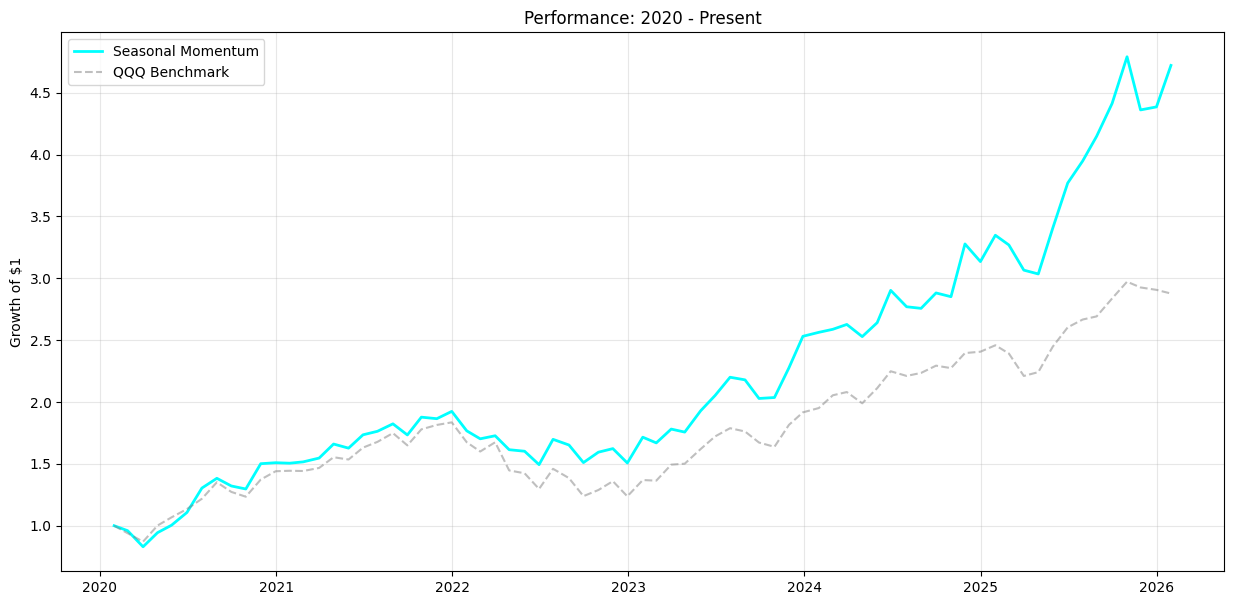

In [3]:
# Plotting pt 1
strategy_data = strat.portfolio_history[strat.portfolio_history.index >= strat.backtest_start]
benchmark_data = strat.benchmark_data[strat.benchmark_ticker].resample('BM').last().pct_change()
aligned_benchmark = benchmark_data.loc[strategy_data.index]

# Cumulative calc
strat_cum = strategy_data['Total Value'] / strategy_data['Total Value'].iloc[0]
bench_cum = (1 + aligned_benchmark).cumprod()
bench_cum = bench_cum / bench_cum.iloc[0]

# Plot
plt.figure(figsize=(15, 7))
plt.plot(strat_cum, label='Seasonal Momentum', color='cyan', linewidth=2)
plt.plot(bench_cum, label='QQQ Benchmark', color='grey', alpha=0.5, linestyle='--')
plt.title('Performance: 2020 - Present')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Overall returns show positive growth when picking the top 10 highest movers, added a 10 year buffer so companies who IPO's later show up without being added to returns before they actually did so. That's also why the dataset has NaN and Null values for some stocks since per our function we dont start until start date (2020)

The 347% return shows that without any friction or anything (in perfect world) that return shows when only trading the highest on seasonality

In [4]:
# Initialize stress testing and factorization
strat = SeasonalETF(start_date='2020-01-01')
strat.get_universe()
strat.ingest_data()
strat.calculate_seasonality()

# Run 1: 0%
print("--- SIMULATION 1: NO FEES ---")
strat.run_backtest(initial_capital=10000)
history_gross = strat.portfolio_history.copy()

# Run 2: 0.1% Fee per month
print("\n--- SIMULATION 2: WITH FEES (0.1%) ---")
strat.run_backtest(initial_capital=10000, transaction_cost=0.001)
history_net = strat.portfolio_history.copy()

--- Fetching NASDAQ 100 Universe ---
Successfully loaded 102 tickers.

--- Ingesting Data (Start: 2010-01-01) ---
Data Loaded. Tradable Universe: 101 tickers.

--- Calculating Seasonal Metrics ---
Seasonal Rankings Calculated.
--- SIMULATION 1: NO FEES ---

--- Running Backtest (Cost: 0.0%) ---
Backtest Complete.
Final Capital: $47,201.29
Total Return:  372.01%

--- SIMULATION 2: WITH FEES (0.1%) ---

--- Running Backtest (Cost: 0.1%) ---
Backtest Complete.
Final Capital: $43,920.68
Total Return:  339.21%


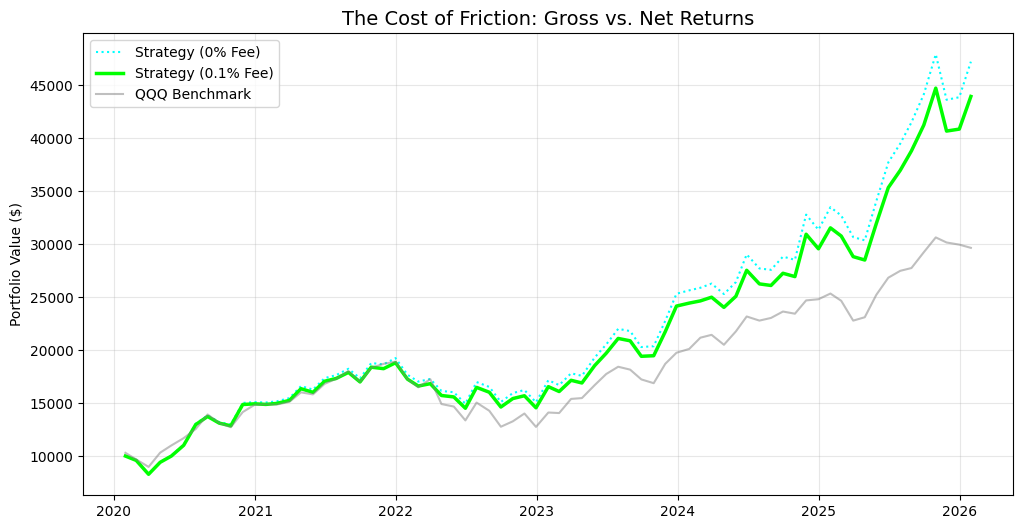

Total profits lost to fees: $3,280.61


In [5]:
import matplotlib.pyplot as plt

# Slice to Backtest Start
start_date = strat.backtest_start
gross = history_gross[history_gross.index >= start_date]['Total Value']
net = history_net[history_net.index >= start_date]['Total Value']

# Benchmark
bench = strat.benchmark_data[strat.benchmark_ticker].resample('BM').last().pct_change()
bench_cum = (1 + bench.loc[gross.index]).cumprod() * 10000 # Scale to $10k

# Plot
plt.figure(figsize=(12, 6))

plt.plot(gross, label='Strategy (0% Fee)', color='cyan', linestyle=':')
plt.plot(net, label='Strategy (0.1% Fee)', color='#00ff00', linewidth=2.5) # The Real Line
plt.plot(bench_cum, label='QQQ Benchmark', color='grey', alpha=0.5)

plt.title('The Cost of Friction: Gross vs. Net Returns', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate
diff = gross.iloc[-1] - net.iloc[-1]
print(f"Total profits lost to fees: ${diff:,.2f}")

Ran tests to add factorization for trading on the spread assuming its a 0.1  percent loss on transaction fees.